Двухуровневый пайплайн

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import os

from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm
from tqdm import trange
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from typing import List

from torch.utils.data import DataLoader, Dataset, TensorDataset

from catboost import CatBoostRanker, Pool
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

!pip3 install gdown


import gdown
# train
url = "https://drive.google.com/file/d/1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-/view?usp=drive_link"
output = 'df_train.csv'
gdown.download(url, output, quiet=False)

# test
url = "https://drive.google.com/file/d/11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG/view?usp=drive_link"
output = 'df_test.csv'
gdown.download(url, output, quiet=False)

# users, items
users = pd.read_csv('/kaggle/input/recsyshw3/users.csv')
items = pd.read_csv('/kaggle/input/recsyshw3/items.csv')

users.to_csv('users.csv', index=False)
items.to_csv('items.csv', index=False)
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

### Этап 1 - предобработка и обучение модели

In [77]:
df_train['last_watch_dt'] = pd.to_datetime(df_train['last_watch_dt'])

value_counts = df_train['item_id'].value_counts()
filtered_values = value_counts[value_counts > 2].index
df_train = df_train[df_train['item_id'].isin(filtered_values)].copy()

last_date = df_train['last_watch_dt'].max()
start_date = last_date - pd.Timedelta(days=30)

valid_stage_1 = df_train[(df_train['last_watch_dt'] >= start_date) & (df_train['last_watch_dt'] <= last_date)]
train_stage_1 = df_train[~df_train.index.isin(valid_stage_1.index)]

train_users = train_stage_1['user_id'].unique()
train_items = train_stage_1['item_id'].unique()

valid_stage_1 = valid_stage_1[valid_stage_1['user_id'].isin(train_users) & valid_stage_1['item_id'].isin(train_items)]

user_le = LabelEncoder()
item_le = LabelEncoder()

train_stage_1['user_id'] = user_le.fit_transform(train_stage_1['user_id'])
train_stage_1['item_id'] = item_le.fit_transform(train_stage_1['item_id'])

valid_stage_1['user_id'] = user_le.transform(valid_stage_1['user_id'])
valid_stage_1['item_id'] = item_le.transform(valid_stage_1['item_id'])

train_stage_1.to_csv('train_stage_1.csv', index=False)
valid_stage_1.to_csv('valid_stage_1.csv', index=False)
train_stage_1 = pd.read_csv('/kaggle/input/recsyshw3/train_stage_1.csv')
valid_stage_1 = pd.read_csv('/kaggle/input/recsyshw3/valid_stage_1.csv')

In [ ]:
df_test['last_watch_dt'] = pd.to_datetime(df_test['last_watch_dt'])

value_counts = df_train['item_id'].value_counts()
filtered_values = value_counts[value_counts > 2].index
test_prepr = df_test[df_test['item_id'].isin(filtered_values)].copy()

user_le = LabelEncoder()
item_le = LabelEncoder()

test_prepr['user_id'] = user_le.fit_transform(test_prepr['user_id'])
test_prepr['item_id'] = item_le.fit_transform(test_prepr['item_id'])

test_prepr.to_csv('test_prepr.csv', index=False)

###  ALS

In [44]:
!pip install tqdm

In [ ]:
class ALS():

  def __init__(self, rank=5, lambda_reg=0.01, max_epochs = 10, tolerance=1e-3):
    self.rank = rank
    self.lambda_reg = lambda_reg
    self.max_epochs = max_epochs
    self.tolerance = tolerance

    self.U = None
    self.V = None
    self.num_users = None
    self.num_items = None
    self.prev_rmse = float('inf')

  def fit(self, train_stage_1):
    user_ids = train_stage_1["user_id"].astype("category").cat.codes
    item_ids = train_stage_1["item_id"].astype("category").cat.codes
    weights = train_stage_1["target"].astype(np.float32)

    R = coo_matrix((weights, (user_ids, item_ids)))
    num_users, num_items = R.shape
    self.num_users = num_users
    self.num_items = num_items

    np.random.seed(42)
    U = np.random.rand(num_users, self.rank)
    V = np.random.rand(num_items, self.rank)
    self.U = U
    self.V = V

    for epoch in trange(self.max_epochs, desc="Training ALS"):
        user_indices = {}
        ratings = {}

        # обновление U
        movie_indices = {}
        ratings = {}

        for i, j, r in zip(R.row, R.col, R.data):

            if i not in movie_indices:
                movie_indices[i] = []
                ratings[i] = []
            movie_indices[i].append(j)
            ratings[i].append(r)

        for user_id, indices in movie_indices.items():
            V_selected = V[indices]
            user_ratings = np.array(ratings[user_id])
            I =  np.eye(self.rank)
            first_param = (V_selected.T @ V_selected + self.lambda_reg * I)
            second_param = (V_selected.T @ user_ratings)
            U[user_id] = np.linalg.solve(first_param, second_param)

        # обновление V
        user_indices = {}
        ratings = {}

        for i, j, r in zip(R.row, R.col, R.data):

            if j not in user_indices:
                user_indices[j] = []
                ratings[j] = []
            user_indices[j].append(i)
            ratings[j].append(r)

        for item_id, indices in user_indices.items():
            U_selected = U[indices]
            user_ratings = np.array(ratings[item_id])
            I =  np.eye(self.rank)
            first_param = (U_selected.T @ U_selected + self.lambda_reg * I)
            second_param = (U_selected.T @ user_ratings)
            V[item_id] = np.linalg.solve(first_param, second_param)

        current_rmse = self.RMSE(R)

        if abs(current_rmse - self.prev_rmse) <= self.tolerance:
            break
        self.prev_rmse = current_rmse
        self.U = U
        self.V = V

  def predict_score(self, user_id, item_id):
    score = self.U[user_id]  @ self.V[item_id]
    return score

  def recommend_topk(self, user_id, top_k ):
    scores = self.U[user_id] @ self.V.T
    top_k_recommendations = np.argsort(-scores)[:top_k]
    return top_k_recommendations

  def RMSE(self, R):
    squared_errors = []

    for i, j, r in zip(R.row, R.col, R.data):
        pred_rating = self.U[i] @ self.V[j].T
        squared_errors.append((r - pred_rating) ** 2)

    return np.sqrt(np.mean(squared_errors))


In [82]:
model = ALS(rank = 5,lambda_reg=0.01, max_epochs=10, tolerance=1e-4)

In [46]:
model.fit(train_stage_1)

Training ALS: 100%|██████████| 10/10 [05:33<00:00, 33.34s/it]


In [ ]:
user_id = 4
top_k = 5

top_als_items = model.recommend_topk(user_id, top_k)
print("Recommendations for user", user_id, "(top",top_k,") :")
print(top_als_items)

Recommendations for user 4 (top 5 ) :
[1998 5793 3908 6708 6219]


In [16]:
user_id = 3
item_id = 13
prediceted_score = model.predict_score(user_id, item_id)
print("cкор",user_id, "юзера c", item_id, "айтемом = ",  prediceted_score)

cкор 3 юзера c 13 айтемом =  82.93586275466636


In [ ]:
with open('als_model_5_epochs.pkl', 'wb') as f:
    pickle.dump(model, f)


In [ ]:
with open('/kaggle/working/als_model.pkl', 'rb') as f:
    als_model = pickle.load(f)



### 2 Этап. Генерация и сборка признаков. 


### Работа с датой:

In [ ]:
test = pd.read_csv('/kaggle/input/recsyshw3/test_prepr.csv')
valid_stage_1['last_watch_dt'] = pd.to_datetime(valid_stage_1['last_watch_dt'], errors='coerce')
train_stage_1['last_watch_dt'] = pd.to_datetime(train_stage_1['last_watch_dt'], errors='coerce')

valid_stage_1 = valid_stage_1.sort_values(by='last_watch_dt')
train_stage_1 = train_stage_1.sort_values(by='last_watch_dt')

test['last_watch_dt'] = pd.to_datetime(test['last_watch_dt'], errors='coerce')
test = test.sort_values(by='last_watch_dt')

merged_users = valid_stage_1.merge(users, on="user_id")
merged_df = merged_users.merge(items, on="item_id")

merged_users_test = test.merge(users, on="user_id")
merged_df_test = merged_users_test.merge(items, on="item_id")

### Все признаки:

In [20]:
def calculate_features_up_to_day(day, train_data):
    data_up_to_day = train_data[train_data['last_watch_dt'] < day]

    avg_watched_pct = data_up_to_day.groupby('user_id')['watched_pct'].mean().fillna(0)# признак юзера

    avg_dur = data_up_to_day.groupby('user_id')['total_dur'].mean().fillna(0)#признак юзера

    item_avg_pct = data_up_to_day.groupby('item_id')['watched_pct'].mean().fillna(0)#признак айтема

    data_up_to_day['film_age_at_watch'] = data_up_to_day['last_watch_dt'].dt.year - data_up_to_day['release_year']#признак айтема

    data_up_to_day = data_up_to_day.assign(country=train_data[train_data['last_watch_dt'] < day]['countries'].str.split(', ').str[0])
    country_ratio = (
        data_up_to_day.groupby(['user_id', 'country'])['item_id'].transform('count')
        / data_up_to_day.groupby('user_id')['item_id'].transform('count')
    ).fillna(0)
    user_country_pct = country_ratio.fillna(0) #доля просмотров пользователем фильмов этой страны (юзер-айтем)

    age_counts = (
        data_up_to_day[~data_up_to_day['age'].isna()]
        .groupby(['item_id', 'age'])
        .size()
        .reset_index(name='count')
    )
    most_common_age = (
        age_counts
        .sort_values('count', ascending=False)
        .drop_duplicates('item_id')
        .set_index('item_id')['age']
    )
    item_mode_age = data_up_to_day['item_id'].map(most_common_age) #самая частая возрастная категория зрителя у фильма (юзер-айтем)

    user_age_matches_items = (data_up_to_day['age'] == item_mode_age).astype(int) #совпадает ли возрастная категория пользователя с наиб частой категорией, смотрящей этот фильм (юзер-айтем)

    data_up_to_day['is_old_film'] = (data_up_to_day['film_age_at_watch'] > 20).astype(int)  # старше ли фильм 20 лет (айтем)

    user_old_film_pct = data_up_to_day.groupby('user_id')['is_old_film'].transform('mean') #доля просмотренных юзером  фильмов, которые старше 20 лет (юзер-айтем)

    usr_like_old_flms = (user_old_film_pct > 0.5).astype(int) #предпочитает ли юзер старые (старше 20 лет) фильмы (юзер-айтем)

    user_item_interaction_count = (
        data_up_to_day.groupby(['user_id', 'item_id'])
        .size()
        .reset_index(name='user_item_interaction_count')  #сколько раз юзер смотрел этот фильм (юзер-айтем)
    )

    return avg_watched_pct, avg_dur, item_avg_pct, data_up_to_day['film_age_at_watch'], user_country_pct, item_mode_age, user_age_matches_items, data_up_to_day['is_old_film'], user_old_film_pct, usr_like_old_flms, user_item_interaction_count

In [ ]:
tqdm.pandas()
merged_features = []

for day in tqdm(valid_stage_1['last_watch_dt'].unique(), desc="Processing days"):
    avg_watched_pct, avg_dur, item_avg_pct, film_age_at_watch, user_country_pct, item_mode_age, user_age_matches_items, is_old_film, user_old_film_pct, usr_like_old_flms, user_item_interaction_count = calculate_features_up_to_day(day, merged_df)

    day_features = valid_stage_1[valid_stage_1['last_watch_dt'] == day].copy()

    day_features['average_watched_pct'] = day_features['user_id'].map(avg_watched_pct)
    day_features['average_dur'] = day_features['user_id'].map(avg_dur)
    day_features['item_avg_pct'] = day_features['item_id'].map(item_avg_pct)
    day_features['film_age_at_watch'] = day_features['user_id'].map(film_age_at_watch)
    day_features['user_country_pct'] = day_features['user_id'].map(user_country_pct)
    day_features['item_mode_age'] = day_features['item_id'].map(item_mode_age)
    day_features['user_age_matches_items'] = day_features['user_id'].map(user_age_matches_items)
    day_features['is_old_film'] = day_features['user_id'].map(is_old_film)
    day_features['user_old_film_pct'] = day_features['user_id'].map(user_old_film_pct)
    day_features['usr_like_old_flms'] = day_features['user_id'].map(usr_like_old_flms)

    day_features['user_item_interaction_count'] = day_features.apply(
        lambda x: user_item_interaction_count[
            (user_item_interaction_count['user_id'] == x['user_id']) &
            (user_item_interaction_count['item_id'] == x['item_id'])
        ]['user_item_interaction_count'].values[0] if not user_item_interaction_count[
            (user_item_interaction_count['user_id'] == x['user_id']) &
            (user_item_interaction_count['item_id'] == x['item_id'])
        ].empty else 0, axis=1
    )

    merged_features.append(day_features)

train_df_with_features = pd.concat(merged_features, axis=0)


In [ ]:
merged_features_test = []

for day in tqdm(valid_stage_1['last_watch_dt'].unique(), desc="Processing days"):
    avg_watched_pct, avg_dur, item_avg_pct, film_age_at_watch, user_country_pct, item_mode_age, user_age_matches_items, is_old_film, user_old_film_pct, usr_like_old_flms, user_item_interaction_count = calculate_features_up_to_day(day, merged_df_test)

    day_features = valid_stage_1[valid_stage_1['last_watch_dt'] == day].copy()

    day_features['average_watched_pct'] = day_features['user_id'].map(avg_watched_pct)
    day_features['average_dur'] = day_features['user_id'].map(avg_dur)
    day_features['item_avg_pct'] = day_features['item_id'].map(item_avg_pct)
    day_features['film_age_at_watch'] = day_features['user_id'].map(film_age_at_watch)
    day_features['user_country_pct'] = day_features['user_id'].map(user_country_pct)
    day_features['item_mode_age'] = day_features['item_id'].map(item_mode_age)
    day_features['user_age_matches_items'] = day_features['user_id'].map(user_age_matches_items)
    day_features['is_old_film'] = day_features['user_id'].map(is_old_film)
    day_features['user_old_film_pct'] = day_features['user_id'].map(user_old_film_pct)
    day_features['usr_like_old_flms'] = day_features['user_id'].map(usr_like_old_flms)

    day_features['user_item_interaction_count'] = day_features.apply(
        lambda x: user_item_interaction_count[
            (user_item_interaction_count['user_id'] == x['user_id']) &
            (user_item_interaction_count['item_id'] == x['item_id'])
        ]['user_item_interaction_count'].values[0] if not user_item_interaction_count[
            (user_item_interaction_count['user_id'] == x['user_id']) &
            (user_item_interaction_count['item_id'] == x['item_id'])
        ].empty else 0, axis=1
    )

    merged_features_test.append(day_features)

test_df_with_features = pd.concat(merged_features_test, axis=0)

Processing days: 100%|██████████| 31/31 [06:58<00:00, 13.49s/it]


In [24]:
train_df_with_features.to_csv("train_df_with_features.csv")
test_df_with_features.to_csv("test_df_with_features.csv")

In [23]:
train_df_with_features = pd.read_csv("/kaggle/working/train_df_with_features.csv")
test_df_with_features = pd.read_csv("/kaggle/working/test_df_with_features.csv")

<ipython-input-23-af4053d7cf94>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df_with_features = pd.read_csv("/kaggle/working/train_df_with_features.csv")



### 3 Этап. Обучение финального ранкера 
В этом этапе будет обучаться ранкер. В качестве ранкера используется [catboost](https://catboost.ai/)





In [ ]:
!pip install catboost
!pip install shap
!pip install ipywidgets

Для начала вычислим скоры между всеми юзерами и айтемами

In [25]:
als_scores = []
for user_id, item_id in zip(train_df_with_features['user_id'], train_df_with_features['item_id']):
    score = model.predict_score(user_id, item_id)
    als_scores.append(score)

train_df_with_features['als_score'] = als_scores

In [ ]:
train_df_with_features = train_df_with_features.sample(frac=0.23, random_state=42)

In [27]:
max_score = train_df_with_features['als_score'].max()

categories = [
    (train_df_with_features['als_score'] >= 0) & (train_df_with_features['als_score'] < 0.001 * max_score),
    (train_df_with_features['als_score'] >= 0.001 * max_score) & (train_df_with_features['als_score'] < 0.008 * max_score),
    (train_df_with_features['als_score'] >= 0.008 * max_score) & (train_df_with_features['als_score'] < 0.015 * max_score),
    (train_df_with_features['als_score'] >= 0.015 * max_score) & (train_df_with_features['als_score'] < 0.04 * max_score),
    (train_df_with_features['als_score'] >= 0.04 * max_score) & (train_df_with_features['als_score'] < 0.07 * max_score),
    (train_df_with_features['als_score'] >= 0.07 * max_score) & (train_df_with_features['als_score'] < 0.6 * max_score),
    (train_df_with_features['als_score'] >= 0.6 * max_score)
]


choices = [0, 1, 2, 3, 4, 5, 6]

train_df_with_features['category of als'] = np.select(categories, choices, default = 1)


In [28]:
X_train = train_df_with_features.copy()
y_train = X_train['item_id']
group_train = train_df_with_features['category of als']
X_train = X_train.drop(['item_id'], axis = 1)
X_train = X_train.drop(['category of als'], axis = 1)

X_valid = test_df_with_features.copy()

In [29]:
cat_features = [ "item_mode_age", "last_watch_dt"]

X_train[cat_features] = X_train[cat_features].fillna("nan").astype(str)
X_valid[cat_features] = X_valid[cat_features].fillna("nan").astype(str)

group_sizes = group_train.value_counts()
print(group_sizes)


category of als
3    55636
4    54303
1    33956
2    14582
5    10288
0    10168
6        7
Name: count, dtype: int64


In [30]:
train_sorted = X_train.copy()
train_sorted['item_id'] = y_train
train_sorted['category of als'] = group_train

train_sorted = train_sorted.sort_values(by='category of als').reset_index(drop=True)

In [31]:
y_train = train_sorted['item_id']
group_train = train_sorted['category of als']
X_train = train_sorted.drop(['item_id', 'category of als'], axis=1)

In [ ]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=group_train,
    cat_features= ["item_mode_age", "last_watch_dt"]
)

catboost_model = CatBoostRanker(
    iterations=30,            
    depth=3,                   
    learning_rate=0.1,         
    loss_function='YetiRank', 
    cat_features=cat_features,
    thread_count=2,           
    verbose=10
)


In [44]:
catboost_model.fit(train_pool, early_stopping_rounds=10)

Groupwise loss function. OneHotMaxSize set to 10
0:	total: 1m 5s	remaining: 31m 53s
10:	total: 11m 42s	remaining: 20m 13s
20:	total: 22m 18s	remaining: 9m 33s
29:	total: 31m 47s	remaining: 0us


In [ ]:
missing_cols = set(X_train.columns) - set(X_valid.columns)
for col in missing_cols:
    X_valid[col] = 0  


In [55]:
print(X_train.columns.tolist())
print(X_valid.columns.tolist())


['Unnamed: 0', 'user_id', 'last_watch_dt', 'total_dur', 'watched_pct', 'target', 'average_watched_pct', 'average_dur', 'item_avg_pct', 'film_age_at_watch', 'user_country_pct', 'item_mode_age', 'user_age_matches_items', 'is_old_film', 'user_old_film_pct', 'usr_like_old_flms', 'user_item_interaction_count', 'als_score']
['Unnamed: 0', 'user_id', 'item_id', 'last_watch_dt', 'total_dur', 'watched_pct', 'target', 'average_watched_pct', 'average_dur', 'item_avg_pct', 'film_age_at_watch', 'user_country_pct', 'item_mode_age', 'user_age_matches_items', 'is_old_film', 'user_old_film_pct', 'usr_like_old_flms', 'user_item_interaction_count', 'als_score']


In [56]:
X_valid["last_watch_dt"] = X_valid["last_watch_dt"].astype(str)
X_train["last_watch_dt"] = X_train["last_watch_dt"].astype(str)

valid_pool = Pool(
    data=X_valid,
    cat_features= ["item_mode_age", "last_watch_dt"]
)

y_pred = catboost_model.predict(valid_pool)


In [57]:
y_pred


array([ 0.10708463,  0.04753156,  0.23612031, ...,  0.12047248,
       -0.00994404,  0.08351953])

In [41]:
for i, col in enumerate(X_valid.columns):
    print(f"{i}: {col}")


0: Unnamed: 0
1: user_id
2: item_id
3: last_watch_dt
4: total_dur
5: watched_pct
6: target
7: average_watched_pct
8: average_dur
9: item_avg_pct
10: film_age_at_watch
11: user_country_pct
12: item_mode_age
13: user_age_matches_items
14: is_old_film
15: user_old_film_pct
16: usr_like_old_flms
17: user_item_interaction_count


In [ ]:

catboost_model.save_model('ranker_model.cbm')

ranker_loaded = CatBoostRanker()
ranker_loaded.load_model('/kaggle/input/catboost/other/default/1')


# SHAP - анализ

In [ ]:
import shap

All-NaN slice encountered


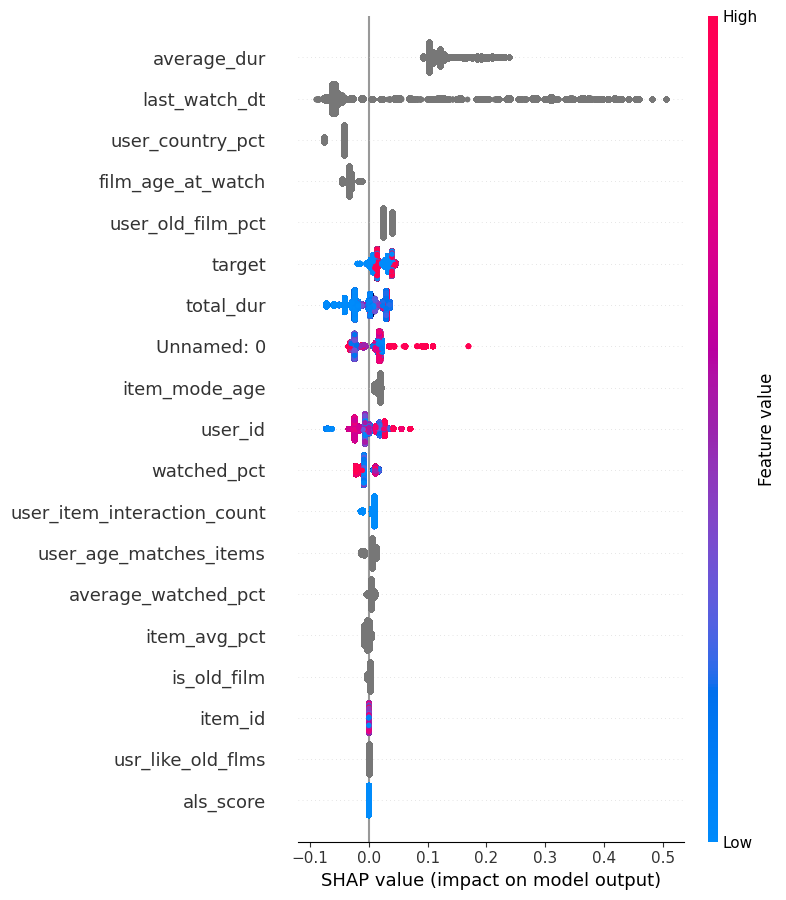

In [ ]:
cat_features = ["item_mode_age", "last_watch_dt"]
X_valid["last_watch_dt"] = X_valid["last_watch_dt"].astype("str")
valid_pool = Pool(data=X_valid, cat_features=cat_features)

explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(valid_pool)

shap.summary_plot(shap_values, X_valid)



### 4 Этап. Инференс лучшего ранкера

In [ ]:
train = df_train.copy()
test = pd.read_csv('/kaggle/input/recsyshw3/test_prepr.csv')
combined = pd.concat([train, test], ignore_index=True)
combined = combined.sample(frac=1).reset_index(drop=True)


In [83]:
model = ALS(rank = 5,lambda_reg=0.01, max_epochs=5, tolerance=1e-4)
model.fit(combined)

Training ALS: 100%|██████████| 5/5 [06:44<00:00, 80.98s/it]


In [ ]:
top_k = 5
all_recommendations = {}

for user_id in df['user_id'].unique():
    recs =  model.recommend_topk(user_id, top_k=top_k)
    all_recommendations[user_id] = recs
